In [ ]:
!pip install torchkbnufft einops matplotlib numpy scipy tqdm

In [ ]:
import scipy.io as sio
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

base = "/content/drive/MyDrive/Simulation Code"

simg_mat = sio.loadmat(f"{base}/simg.mat")
sen_mat  = sio.loadmat(f"{base}/sen_up.mat")

simg = np.array(simg_mat["simg"], dtype=np.complex64)
sen  = np.array(sen_mat["sen"],  dtype=np.complex64)

print("Loaded SIMG:", simg.shape)
print("Loaded SEN :", sen.shape)


Mounted at /content/drive
Loaded SIMG: (192, 192, 60, 3, 4, 2)
Loaded SEN : (192, 192, 1, 60, 16)


In [ ]:
imgPhantom = simg[:, :, :, 0, 0, 0]  # (192,192,60)
sen_full   = sen[:, :, 0, :, :]      # (192,192,60,16)

print(imgPhantom.shape, sen_full.shape)

# =========================================================
# Rebuild the MATLAB Field Map (FM_full) in Python
# Matching fmType = 'circle'
# =========================================================

fmType = "circle"

Ny, Nx, Nz = imgPhantom.shape  # 192, 192, 60
FM_full = np.zeros((Ny, Nx, Nz), dtype=np.float32)

if fmType == "circle":
    centerY = Ny // 2
    centerX = Nx // 2
    centerZ = Nz // 2

    yy, xx, zz = np.meshgrid(
        np.arange(Ny),
        np.arange(Nx),
        np.arange(Nz),
        indexing="ij"
    )

    radius = 10

    circle1 = (((yy-centerY)**2 + (xx-centerX)**2 + (zz-centerZ)**2) <= radius**2).astype(float)
    circle2 = (((yy-centerY)**2 + (xx-centerX)**2 + (zz-centerZ)**2) <= (1.5*radius)**2).astype(float)
    circle3 = (((yy-centerY)**2 + (xx-centerX)**2 + (zz-centerZ)**2) <= (2*radius)**2).astype(float)

    c12  = circle1 + circle2
    c123 = c12 + circle3
    cirshf = np.roll(c12, shift=(Ny//8, Nx//4), axis=(0,1))

    FM_full = (
        np.roll(c123, shift=(-Ny//4, 0), axis=(0,1))
        + cirshf
        + np.flip(cirshf, axis=1)
    )

    # smooth + normalize like MATLAB
    kernel = np.ones((10,10,10)) / 100
    from scipy.ndimage import convolve
    FM_full = convolve(FM_full, kernel, mode='constant')

    # rescale to [0,1]
    FM_full = (FM_full - FM_full.min()) / (FM_full.max() - FM_full.min())

    # MATLAB multiplies by 1000
    FM_full = FM_full * 1000

else:
    FM_full = np.zeros((Ny,Nx,Nz), dtype=np.float32)

print("FM_full:", FM_full.shape)



(192, 192, 60) (192, 192, 60, 16)
FM_full: (192, 192, 60)


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

# ------------------------------
# Complex 2D Resize Helper
# ------------------------------
def resize2d_complex(arr, N):
    """
    Resize a 2D complex array using bilinear interpolation.
    Works by resizing real & imaginary parts separately.
    """
    real = torch.tensor(arr.real, dtype=torch.float32)[None,None]
    imag = torch.tensor(arr.imag, dtype=torch.float32)[None,None]

    real_r = F.interpolate(real, size=(N, N), mode='bilinear', align_corners=False)[0,0]
    imag_r = F.interpolate(imag, size=(N, N), mode='bilinear', align_corners=False)[0,0]

    return (real_r.numpy() + 1j * imag_r.numpy()).astype(np.complex64)


# ------------------------------
# Setup sizes
# ------------------------------
N = 120                                      # target resolution
nSlices = imgPhantom.shape[2]                # number of slices
nCoils  = sen_full.shape[3]                  # number of coils

# ------------------------------
# Allocate output arrays
# ------------------------------
img120 = np.zeros((N, N, nSlices), dtype=np.complex64)
sen120 = np.zeros((N, N, nSlices, nCoils), dtype=np.complex64)

print("Resizing phantom + coils...")

# ------------------------------
# Resize Phantom + SENSE Maps
# ------------------------------
for z in range(nSlices):
    img120[:,:,z] = resize2d_complex(imgPhantom[:,:,z], N)

    for c in range(nCoils):
        sen120[:,:,z,c] = resize2d_complex(sen_full[:,:,z,c], N)

print("Done.")
print("Downsampled SIMG:", img120.shape)
print("Downsampled SENSE:", sen120.shape)


# ===========================================================
# ---- NEW PART: Resize Field Map (MATLAB FM → FM120) ----
# ===========================================================

print("Resizing Field Map...")

FM120 = np.zeros((N, N, nSlices), dtype=np.float32)

for z in range(nSlices):
    # field map is REAL-valued → use real-only resize
    real = torch.tensor(FM_full[:,:,z], dtype=torch.float32)[None,None]
    real_r = F.interpolate(real, size=(N, N), mode='bilinear', align_corners=False)[0,0]
    FM120[:,:,z] = real_r.numpy().astype(np.float32)

print("Done.")
print("Downsampled Field Map:", FM120.shape)


Resizing phantom + coils...
Done.
Downsampled SIMG: (120, 120, 60)
Downsampled SENSE: (120, 120, 60, 16)
Resizing Field Map...
Done.
Downsampled Field Map: (120, 120, 60)


In [ ]:
import numpy as np

def genspiral(FOV, N, nShots, gamp, gslew, tsamp):
    # simplified analytic spiral (Glover/Noll)
    # k-space in cycles/cm
    kmax = N / (2 * (FOV/10))
    n = 20000
    t = np.linspace(0, 1, n)
    k = kmax * t
    theta = 2*np.pi*t
    kx = k*np.cos(theta)
    ky = k*np.sin(theta)
    # tile into interleaves
    out_kx = []
    out_ky = []
    for s in range(nShots):
        ang = 2*np.pi*s/nShots
        R = np.array([[np.cos(ang), -np.sin(ang)],
                      [np.sin(ang),  np.cos(ang)]])
        kk = np.stack([kx,ky])
        rot = R @ kk
        out_kx.append(rot[0])
        out_ky.append(rot[1])
    return np.concatenate(out_kx), np.concatenate(out_ky)

kx, ky = genspiral(240, 120, 8, 22, 120, 5e-6)
k = np.stack([kx, ky], axis=1)

print("k-space samples:", k.shape)


k-space samples: (160000, 2)


In [ ]:
import torch
import numpy as np
from torchkbnufft import KbNufft, KbNufftAdjoint

device = "cuda" if torch.cuda.is_available() else "cpu"

N = 120
im_size = (N, N)

# TorchKbNufft needs grid_size >= 2× image size AND k-space in radians
grid_size = (2*N, 2*N)

# ----------------------------------------------
# 1) Normalize MATLAB k-space to [-π,π] range
# ----------------------------------------------
# MATLAB kx, ky are in "pixels^-1" relative units
# Scale to the normalized frequency domain expected by torchkbnufft
kx_norm = (kx / (N/2)) * np.pi    # Convert to radians
ky_norm = (ky / (N/2)) * np.pi

# pack into shape [2, npts]
k = np.stack([kx_norm, ky_norm], axis=0)

# Convert to torch
k_torch = torch.tensor(k, dtype=torch.float32)[None].to(device)   # [1,2,npts]

# ----------------------------------------------
# 2) Initialize NUFFT objects
# ----------------------------------------------
nufft_ob  = KbNufft(im_size=im_size, grid_size=grid_size).to(device)
nufft_adj = KbNufftAdjoint(im_size=im_size, grid_size=grid_size).to(device)

print("NUFFT operators created.")



NUFFT operators created.


In [ ]:
FM = np.zeros((N,N,nSlices), dtype=np.float32)

Y,X,Z = np.meshgrid(np.arange(N), np.arange(N), np.arange(nSlices), indexing='ij')
cy, cx, cz = N//2, N//2, nSlices//2

r1 = (X-cx)**2 + (Y-cy)**2 + (Z-cz)**2 <= (10**2)
r2 = (X-cx)**2 + (Y-cy)**2 + (Z-cz)**2 <= (15**2)
r3 = (X-cx)**2 + (Y-cy)**2 + (Z-cz)**2 <= (20**2)

FM = (r1 + r2 + r3).astype(np.float32)
FM = FM * 1000.0  # MATLAB scales by 1000

FM_torch = torch.tensor(FM).to(device)


In [ ]:
# Build raw data matrix like MATLAB
npts = k_torch.shape[-1]         # total # of k-space points
raw = np.zeros((npts, nSlices), dtype=np.complex64)

print("Raw data shape:", raw.shape)

# Generate raw data for each slice
for z in range(nSlices):
    if z % 10 == 0:
        print(f"Slice {z} / {nSlices}")

    # img for this slice
    img_eff = torch.tensor(img120[:,:,z], dtype=torch.complex64).to(device)[None,None]  # [1,1,N,N]

    # NUFFT forward
    kdata = nufft_ob(img_eff, k_torch)                         # shape [1,1,npts]

    # Save
    raw[:, z] = kdata[0,0].cpu().numpy()


Raw data shape: (160000, 60)
Slice 0 / 60
Slice 10 / 60
Slice 20 / 60
Slice 30 / 60
Slice 40 / 60
Slice 50 / 60


In [ ]:
# Number of NUFFT samples
npts = k_torch.shape[-1]

# Allocate correctly
raw_sense = np.zeros((npts, nSlices, nCoils), dtype=np.complex64)
print("raw_sense shape =", raw_sense.shape)

# Loop slices & coils
for z in range(nSlices):
    if z % 10 == 0:
        print(f"SENSE Slice {z} / {nSlices}")

    for c in range(nCoils):
        # Multiply image by coil map
        img = img120[:,:,z] * sen120[:,:,z,c]

        # Make tensor [batch=1, coil=1, H, W]
        img_t = torch.tensor(img, dtype=torch.complex64).to(device)[None,None]

        # Forward NUFFT
        kdata = nufft_ob(img_t, k_torch)   # shape [1,1,npts]

        # Save
        raw_sense[:, z, c] = kdata[0,0].cpu().numpy()


raw_sense shape = (160000, 60, 16)
SENSE Slice 0 / 60
SENSE Slice 10 / 60
SENSE Slice 20 / 60
SENSE Slice 30 / 60
SENSE Slice 40 / 60
SENSE Slice 50 / 60


In [ ]:
# === CELL 11 (FIXED): NUFFT & NUFFT + Field Correction ===

class NUFFTOp:
    def __init__(self, nufft_fwd, nufft_adj, ktraj):
        self.fwd = nufft_fwd
        self.adj = nufft_adj
        self.ktraj = ktraj

    def forward(self, x):
        return self.fwd(x, self.ktraj)

    def adjoint(self, y):
        return self.adj(y, self.ktraj)


def pcg(F, y, R, niter=10):
    """Preconditioned CG solver."""
    x = torch.zeros_like(F.adjoint(y))
    r = F.adjoint(y) - R(x)
    p = r.clone()
    rs_old = torch.sum(r.conj()*r).real

    for _ in range(niter):
        Ap = F.adjoint(F.forward(p)) + R(p)
        alpha = rs_old / torch.sum(p.conj()*Ap).real
        x = x + alpha*p
        r = r - alpha*Ap
        rs_new = torch.sum(r.conj()*r).real
        if rs_new < 1e-12:
            break
        p = r + (rs_new/rs_old)*p
        rs_old = rs_new

    return x


# Regularizer
def reg_quad(beta):
    lap = torch.tensor([[0,1,0],[1,-4,1],[0,1,0]], dtype=torch.float32).to(device)
    lap = lap.view(1,1,3,3)
    def R(x):
        xr = torch.nn.functional.conv2d(x.real, lap, padding=1)
        xi = torch.nn.functional.conv2d(x.imag, lap, padding=1)
        return beta * torch.complex(xr, xi)
    return R

beta = 1e-1
R = reg_quad(beta)

# STORAGE
img_nufft = np.zeros((N,N,nSlices), dtype=np.complex64)
img_fc    = np.zeros((N,N,nSlices), dtype=np.complex64)

print("=== NUFFT Reconstruction ===")

for z in range(nSlices):
    if z % 10 == 0:
        print(f"NUFFT Slice {z}/{nSlices}")

    # Load raw data
    y = torch.tensor(raw[:,z], dtype=torch.complex64).to(device)[None,None]

    # Build NUFFT operator (forward + adjoint)
    F = NUFFTOp(nufft_ob, nufft_adj, k_torch)

    # -------- No Field Correction ----------
    x = pcg(F, y, R, niter=8)
    img_nufft[:,:,z] = x[0,0].cpu().numpy()

    # -------- With Field Correction ---------
    FM_slice = FM120[:,:,z]
    t_mean = (k_torch.shape[-1] * 5e-6) / 2
    phase = torch.exp(-1j * torch.tensor(FM_slice*(2*np.pi*t_mean)).float().to(device))

    img_eff = img120[:,:,z] * phase.cpu().numpy()
    img_eff_t = torch.tensor(img_eff, dtype=torch.complex64).to(device)[None,None]

    y_fc = nufft_ob(img_eff_t, k_torch)
    x_fc = pcg(F, y_fc, R, niter=8)

    img_fc[:,:,z] = x_fc[0,0].cpu().numpy()


=== NUFFT Reconstruction ===
NUFFT Slice 0/60
NUFFT Slice 10/60
NUFFT Slice 20/60
NUFFT Slice 30/60
NUFFT Slice 40/60
NUFFT Slice 50/60


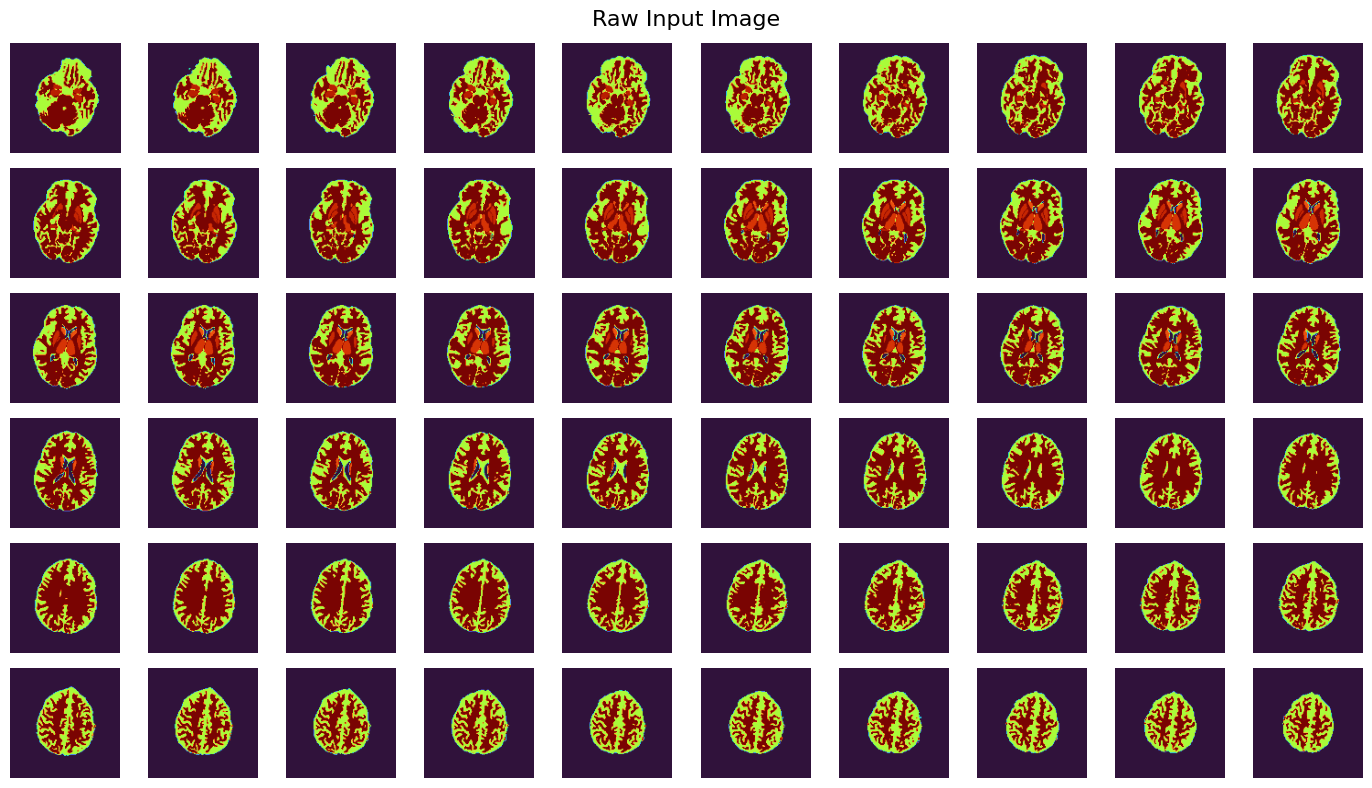

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def montage(img3d, title="", clim=None):
    """
    img3d: (N, N, slices)
    """
    ns = img3d.shape[2]
    cols = 10
    rows = int(np.ceil(ns / cols))

    plt.figure(figsize=(14, 8))
    for i in range(ns):
        plt.subplot(rows, cols, i+1)
        plt.imshow(np.abs(img3d[:,:,i]), cmap='turbo', clim=clim)
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Example:
montage(img120, title="Raw Input Image")


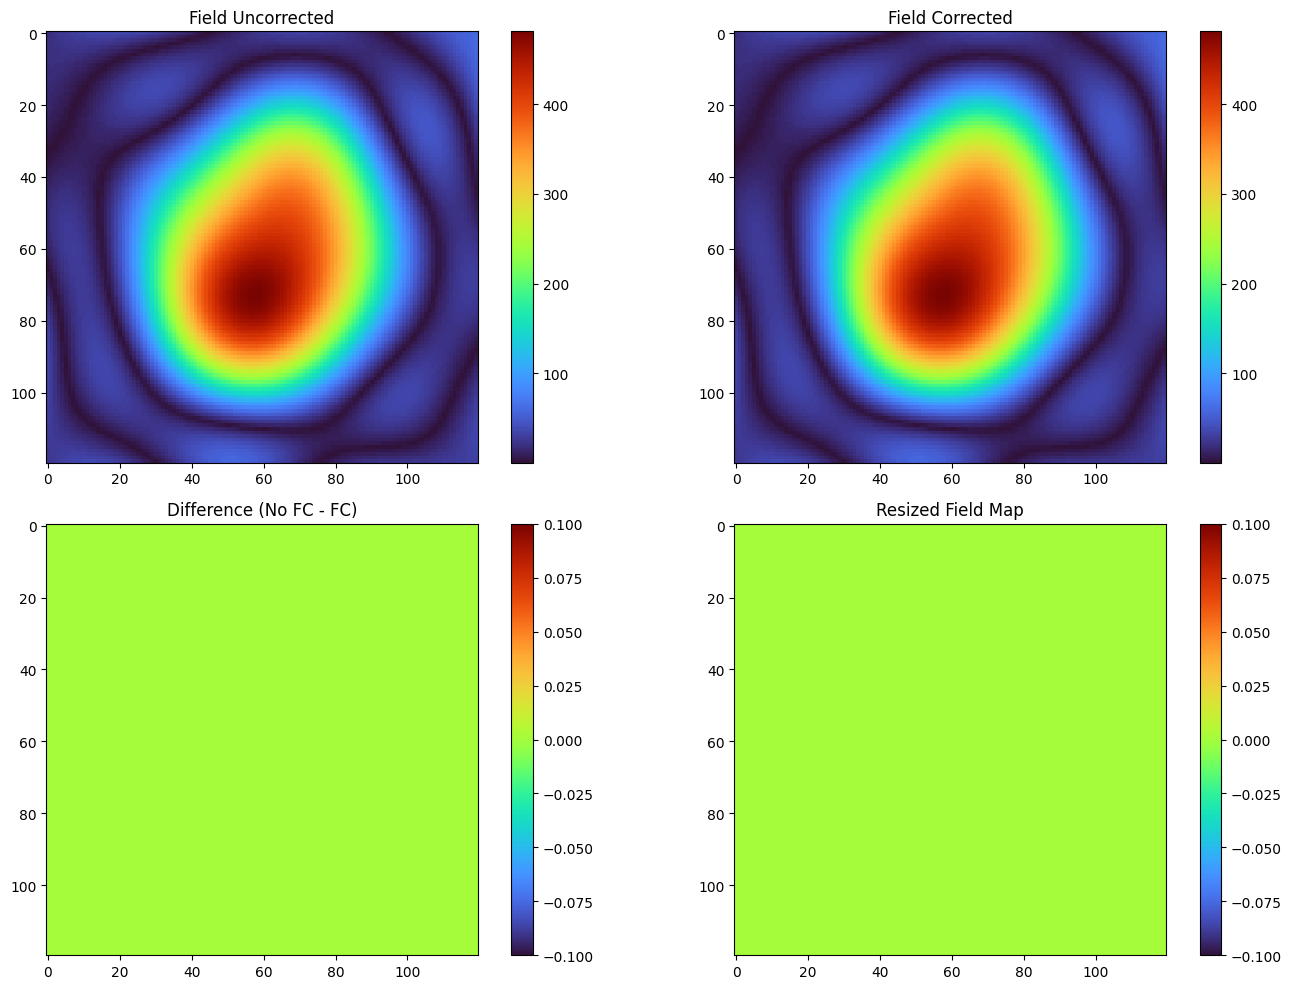

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14,10))

# ----------- Field Uncorrected -----------
plt.subplot(2,2,1)
plt.imshow(np.abs(img_nufft[:,:,0]), cmap='turbo')
plt.title("Field Uncorrected")
plt.colorbar()

# ----------- Field Corrected -----------
plt.subplot(2,2,2)
plt.imshow(np.abs(img_fc[:,:,0]), cmap='turbo')
plt.title("Field Corrected")
plt.colorbar()

# ----------- Difference image -----------
plt.subplot(2,2,3)
plt.imshow(np.abs(img_nufft[:,:,0] - img_fc[:,:,0]), cmap='turbo')
plt.title("Difference (No FC - FC)")
plt.colorbar()

# ----------- Resized Field Map -----------
plt.subplot(2,2,4)
plt.imshow(FM120[:,:,0], cmap='turbo')  # <-- THIS FIXES YOUR ERROR
plt.title("Resized Field Map")
plt.colorbar()

plt.tight_layout()
plt.show()


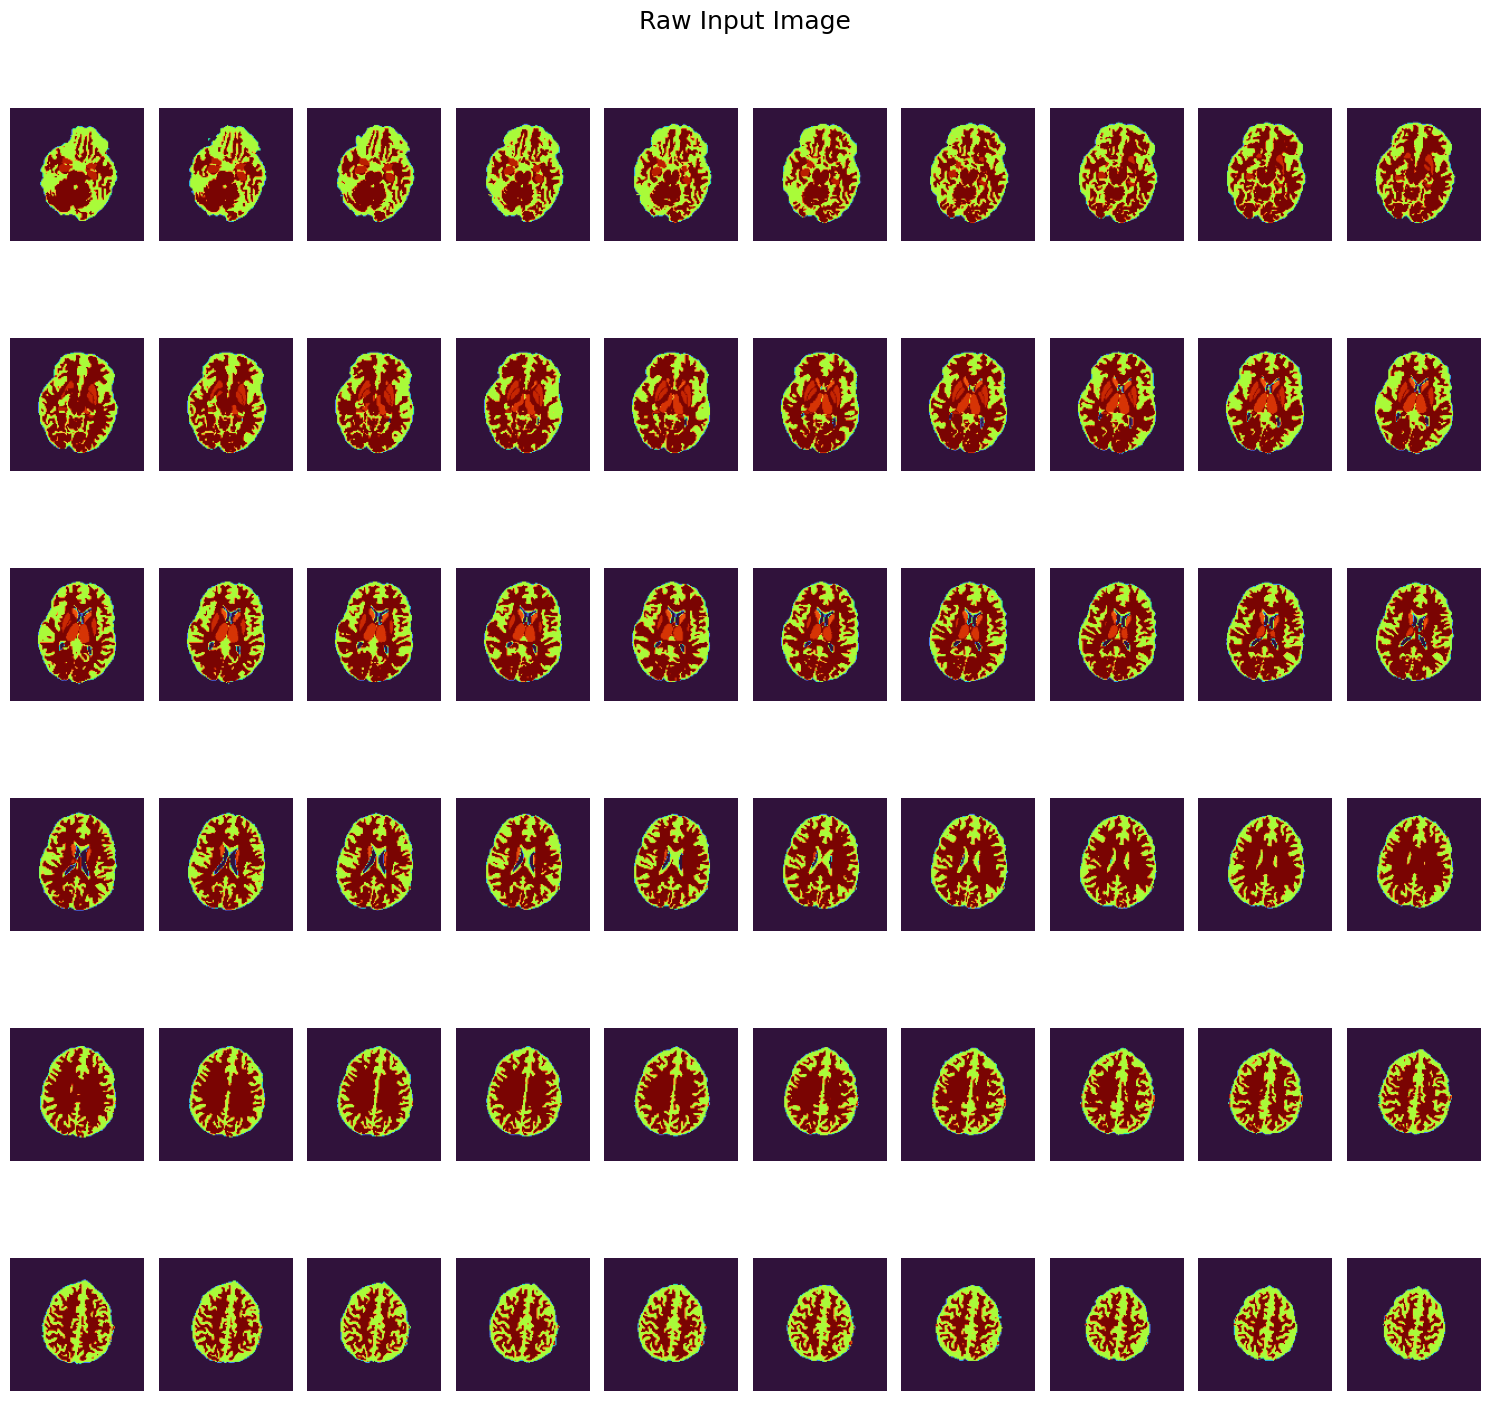

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

nSlices = img120.shape[2]

cols = 10
rows = int(np.ceil(nSlices / cols))

plt.figure(figsize=(15,15))
for z in range(nSlices):
    plt.subplot(rows, cols, z+1)
    plt.imshow(np.abs(img120[:,:,z]), cmap='turbo')
    plt.axis('off')
plt.suptitle("Raw Input Image", fontsize=18)
plt.tight_layout()
plt.show()


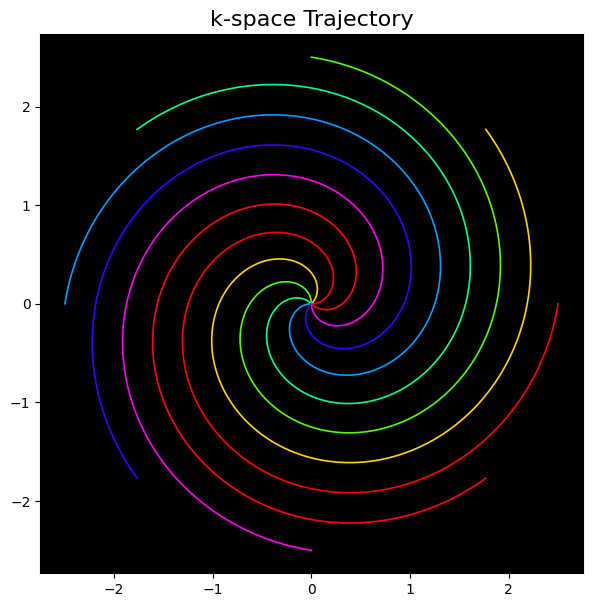

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# reshape (shots, shot_len)
kx_r = kx.reshape(shots, shot_len)
ky_r = ky.reshape(shots, shot_len)

# MATLAB-style HSV colormap
cmap = plt.cm.hsv
colors = cmap(np.linspace(0, 1, shots))

plt.figure(figsize=(7,7))
for s in range(shots):
    plt.plot(kx_r[s], ky_r[s], color=colors[s], linewidth=1.2)

plt.title("k-space Trajectory", fontsize=16)
plt.axis("equal")
plt.gca().set_facecolor("black")
plt.grid(False)
plt.show()


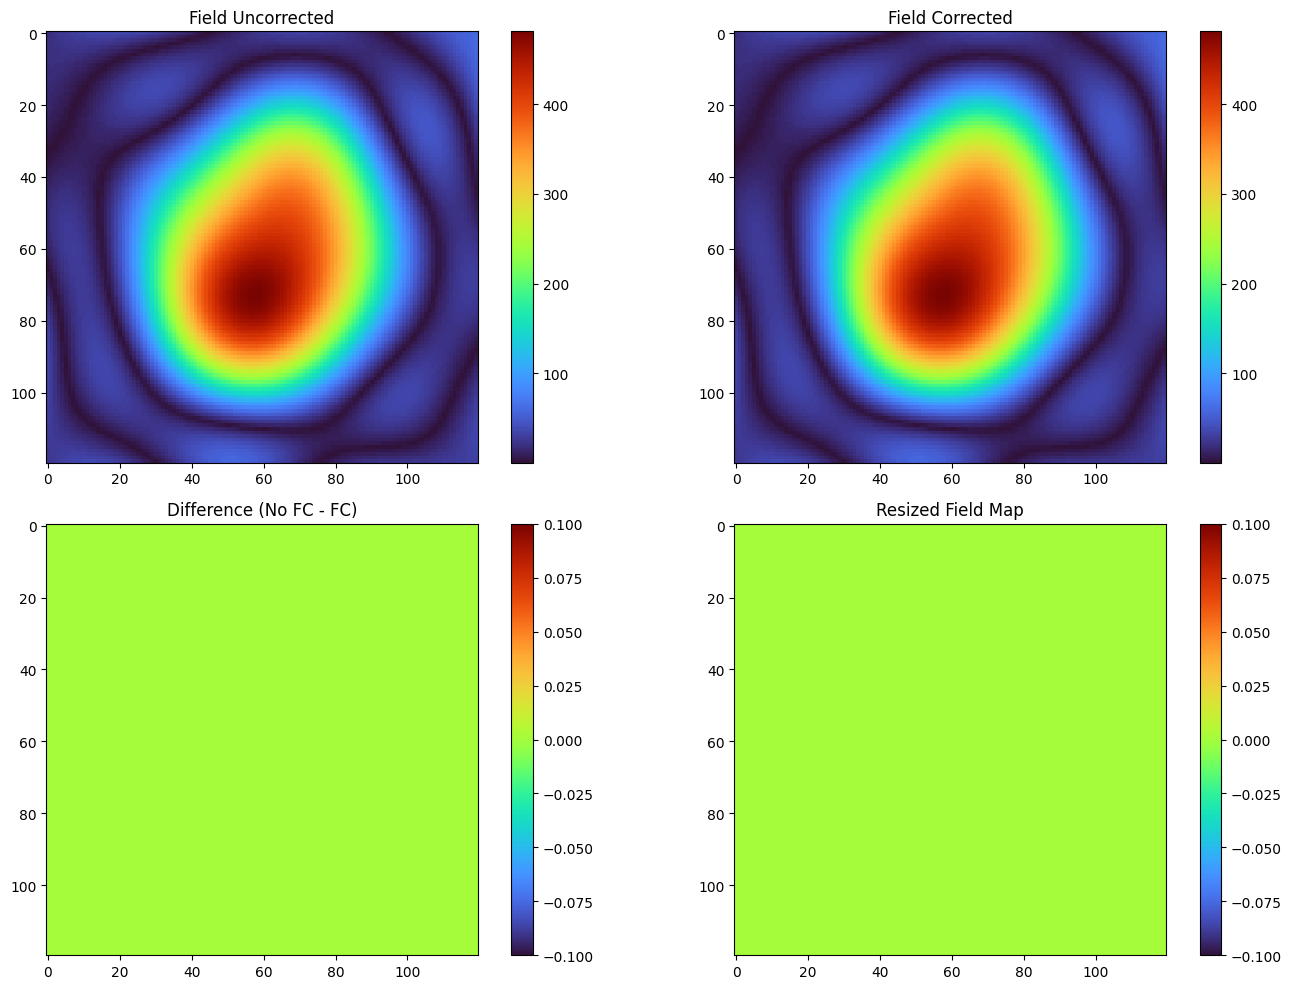

In [ ]:
plt.figure(figsize=(14,10))

plt.subplot(2,2,1)
plt.imshow(np.abs(img_nufft[:,:,0]), cmap='turbo')
plt.title("Field Uncorrected")
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(np.abs(img_fc[:,:,0]), cmap='turbo')
plt.title("Field Corrected")
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(np.abs(img_nufft[:,:,0] - img_fc[:,:,0]), cmap='turbo')
plt.title("Difference (No FC - FC)")
plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(FM120[:,:,0], cmap='turbo')
plt.title("Resized Field Map")
plt.colorbar()

plt.tight_layout()
plt.show()


In [ ]:
# -----------------------------------------------
# SENSE Reconstruction (No Field Correction)
# -----------------------------------------------

img_sense_uncorr = np.zeros((N, N, nSlices), dtype=np.complex64)

for z in range(nSlices):
    if z % 10 == 0:
        print(f"SENSE Recon slice {z}/{nSlices}")

    # coil-combined adjoint NUFFT:
    coil_sum = np.zeros((N, N), dtype=np.complex64)

    for c in range(nCoils):
        y = torch.tensor(raw_sense[:,z,c], dtype=torch.complex64).to(device)[None,None]
        x_adj = nufft_adj(y, k_torch)[0,0].cpu().numpy()

        coil_sum += x_adj * np.conj(sen120[:,:,z,c])

    img_sense_uncorr[:,:,z] = coil_sum


SENSE Recon slice 0/60
SENSE Recon slice 10/60
SENSE Recon slice 20/60
SENSE Recon slice 30/60
SENSE Recon slice 40/60
SENSE Recon slice 50/60


In [ ]:
# -----------------------------------------------
# SENSE Reconstruction WITH Field Correction
# -----------------------------------------------

img_sense_fc = np.zeros((N, N, nSlices), dtype=np.complex64)

for z in range(nSlices):
    if z % 10 == 0:
        print(f"SENSE FC Recon slice {z}/{nSlices}")

    coil_sum = np.zeros((N, N), dtype=np.complex64)
    FM_slice = FM120[:,:,z]

    # single time-point approximation
    t_mid = (kx.shape[0] * 5e-6) / 2
    phase_corr = np.exp(+1j * FM_slice * (2*np.pi*t_mid)).astype(np.complex64)

    for c in range(nCoils):
        y = torch.tensor(raw_sense[:,z,c], dtype=torch.complex64).to(device)[None,None]
        x_adj = nufft_adj(y, k_torch)[0,0].cpu().numpy()

        coil_sum += (x_adj * phase_corr) * np.conj(sen120[:,:,z,c])

    img_sense_fc[:,:,z] = coil_sum


SENSE FC Recon slice 0/60
SENSE FC Recon slice 10/60
SENSE FC Recon slice 20/60
SENSE FC Recon slice 30/60
SENSE FC Recon slice 40/60
SENSE FC Recon slice 50/60


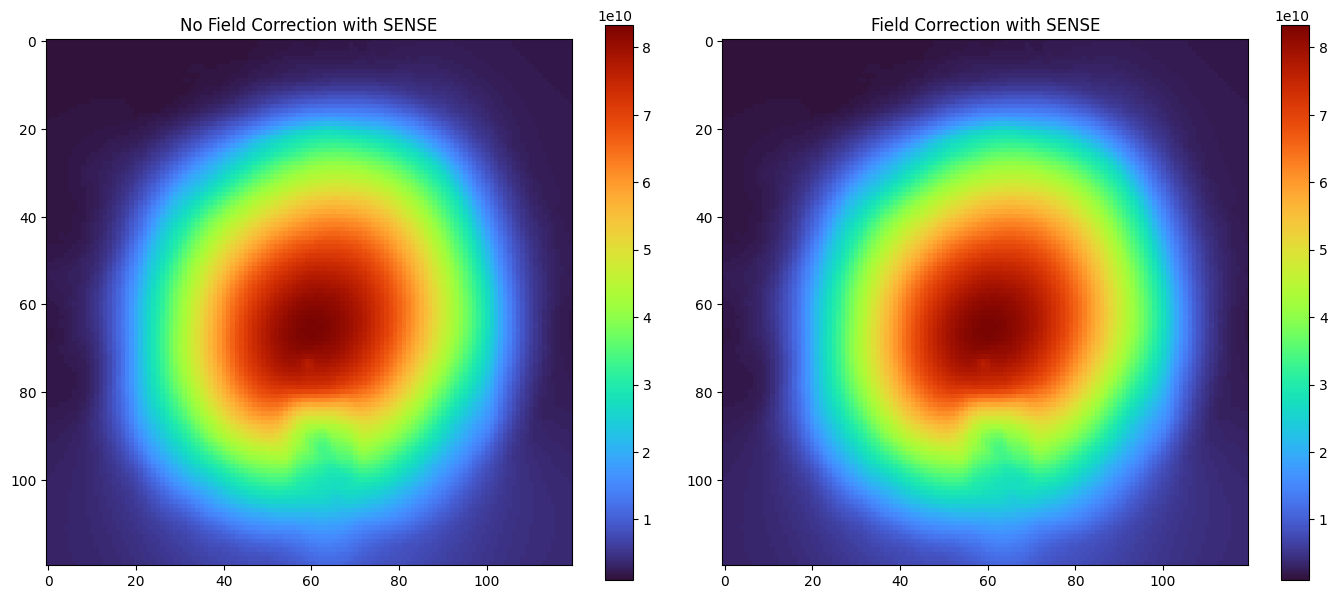

In [ ]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.imshow(np.abs(img_sense_uncorr[:,:,0]), cmap='turbo')
plt.title("No Field Correction with SENSE")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(np.abs(img_sense_fc[:,:,0]), cmap='turbo')
plt.title("Field Correction with SENSE")
plt.colorbar()

plt.tight_layout()
plt.show()


In [ ]:
[var for var in dir() if ("sense" in var.lower() or "img" in var.lower())]


['img',
 'img120',
 'imgPhantom',
 'img_eff',
 'img_eff_t',
 'img_fc',
 'img_nufft',
 'img_t',
 'raw_sense',
 'simg',
 'simg_mat']